In [184]:
# coding: utf-8
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pylab as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cm 
import math
import cv2
#GP-UCB Code
class GPUCB(object):

  def __init__(self, meshgrid, environment, beta=10000000.):
    '''
    beta (optional): Hyper-parameter to tune the exploration-exploitation
    balance. If beta is large, it emphasizes the variance of the unexplored
    solution solution (i.e. larger curiosity)
    '''
    self.meshgrid = np.array(meshgrid)
    self.environment = environment
    self.beta = beta

    self.X_grid = self.meshgrid.reshape(self.meshgrid.shape[0], -1).T
    self.mu = np.array([0. for _ in range(self.X_grid.shape[0])])
    self.sigma = np.array([0.5 for _ in range(self.X_grid.shape[0])])
    self.X = []
    self.T = []
    self.parameter = 1
    self.sp = 0
    self.prev_indx = 0
  
  def distance(self, x1 , y1 , x2 , y2): 
  
    # Calculating distance 
    return math.sqrt(math.pow(x2 - x1, 2) +
                math.pow(y2 - y1, 2) * 1.0)   
    
  def get_y(self, P, Q, x):
    value = (x - P[0])*(Q[1] - P[1])/(Q[0]-P[0]) + P[1]
    return value


  def get_x(self, P, Q, y):
    value = (y - P[1])*(Q[0] - P[0])/(Q[1]-P[1]) + P[0]
    return value
    
        
  def argmax_ucb(self):
    return np.argmax(self.mu + self.sigma * np.sqrt(self.beta))

  def findloc(self,arr, e):
        k=0
        for i in arr:
            #print i,e
            if i[0]== e[0] and i[1]==e[1]:
                return k
            k+=1
        return -1
                   

  def sample_along_the_way(self, P,Q):
        path_length = 0
        if (abs(P[0]-Q[0]) >= abs(P[1]-Q[1])):
            #call function that gives y on passing x

            if P[0] < Q[0]:
                i = P[0]
                while (i + 1/self.parameter < Q[0]):
                    i += 1/self.parameter
                    j = self.get_y(P, Q, i)
                    
                    #print "Mid-way Next Sampling Location is  [",i,",",j,"]"
                    self.sample([int(i), int(j)])
                    path_length+=1
                    gp = GaussianProcessRegressor()
                    gp.fit(self.X, self.T)
                    self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)
                    
                
            else:
                i = Q[0]
                while (i + 1/self.parameter < P[0]):
                    i += 1/self.parameter
                    j = self.get_y(P, Q, i)
                    #print "Mid-way Next Sampling Location is  [",i,",",j,"]"
                    self.sample([int(i), int(j)])
                    path_length+=1
                    gp = GaussianProcessRegressor()
                    gp.fit(self.X, self.T)
                    self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)
                    
            
            
        else:
            #call function that gives x on passing y
             if P[1] < Q[1] :
                i = P[1]
                while (i + 1/self.parameter < Q[1]):
                    i += 1/self.parameter
                    j = self.get_x(P, Q, i)
                    #print "Mid-way Next Sampling Location is  [",j,",",i,"]"
                    self.sample([int(j), int(i)])
                    path_length+=1
                    gp = GaussianProcessRegressor()
                    gp.fit(self.X, self.T)
                    self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)
                    
            
             else:
                i = Q[1]
                while (i + 1/self.parameter < P[1]):
                    i += 1/self.parameter
                    j = self.get_x(P, Q, i)
                    #print "Mid-way Next Sampling Location is  [",j,",",i,"]"
                    self.sample([int(j), int(i)])
                    path_length+=1
                    gp = GaussianProcessRegressor()
                    gp.fit(self.X, self.T)
                    self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)
                    
        return path_length
                    
                

  def learn(self):
    dist = 0
#     minimum_mean = min(self.mu)
#     for i in range(len(self.mu)):
#         if self.X_grid[i] in self.X:
#             self.mu[i] = minimum_mean
#     self.mu[self.prev_indx] = min(self.mu)
#     self.sigma[self.prev_indx] = min(self.sigma)
    grid_idx = self.argmax_ucb()
#     self.prev_indx = grid_idx
#     print grid_idx
    
    if len(self.X)>0:
        P = self.X[-1]
        Q = self.X_grid[grid_idx]
        #print "dist",self.distance(P[0],P[1],Q[0],Q[1])
        dist=self.distance(P[0],P[1],Q[0],Q[1])
        
    if len(self.X) > 0 and self.parameter > 0:
        P = self.X[-1]
        Q = self.X_grid[grid_idx]
        #print P,Q
        pl = self.sample_along_the_way(P,Q)
        #print pl,
        #v = self.variance_of_the_path(P,Q)
        #print v
        
    #print "Next Sampling Location is  ", self.X_grid[grid_idx]
    self.sp += 1
    self.sample(self.X_grid[grid_idx])
    gp = GaussianProcessRegressor()
    gp.fit(self.X, self.T)
    self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)
    #print self.X, self.T
    return self.mu, dist

  def sample(self, x):
    t = self.environment.sample(x)
    self.X.append(x)
    self.T.append(t)

  def plot(self):
    
    fig = plt.figure(figsize=(18, 8))
    fig.suptitle("Iteration %02d" %self.sp)
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
        self.mu.reshape(self.meshgrid[0].shape), alpha=0.5, color='g')
    ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
        self.environment.sample(self.meshgrid), alpha=0.5, color='b')
    ax.scatter([x[0] for x in self.X], [x[1] for x in self.X], self.T, c='r',
        marker='o', alpha=1.0)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1 = plt.subplot(122)
    
    ax1.pcolormesh(self.meshgrid[0], self.meshgrid[1],
        self.mu.reshape(self.meshgrid[0].shape))
  
    plt.savefig('fig_%02d.png' % len(self.X))




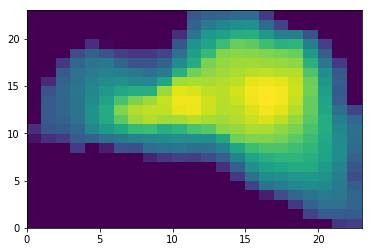

In [185]:

if __name__ == '__main__':
  image=['round.png','tahoe.png','holly_water.png','golden.png','crater.png','irogami.png','jordan.png','pleasant.png','tuttle.png','blue.png','maskenthine.png','wagon_train.png']
  img=cv2.imread("lake/"+image[2])
  img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (24,24))
  h=img.shape[0]
  w=img.shape[1]
  plt.pcolormesh( np.arange(0, w, 1),  np.arange(0, h, 1),img)
  #print img

  class DummyEnvironment(object):
    def sample(self, j):
      #print img[j[1],j[0]]
      return img[j[1],j[0]]

  x = np.arange(0, w, 1)
  y = np.arange(0, h, 1)
  env = DummyEnvironment()
  agent = GPUCB(np.meshgrid(x, y), env)


  

Computational time 41.771565
trajectory length 141.357014721


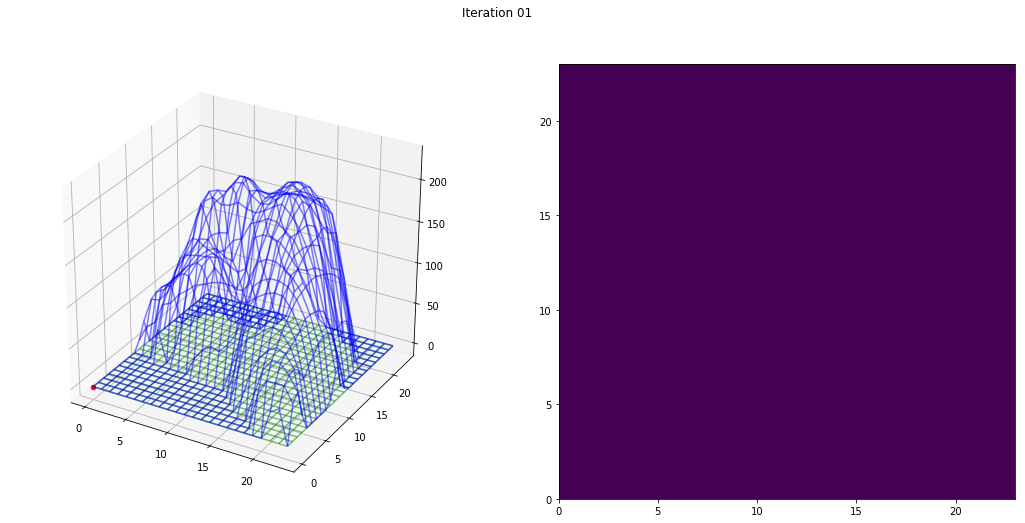

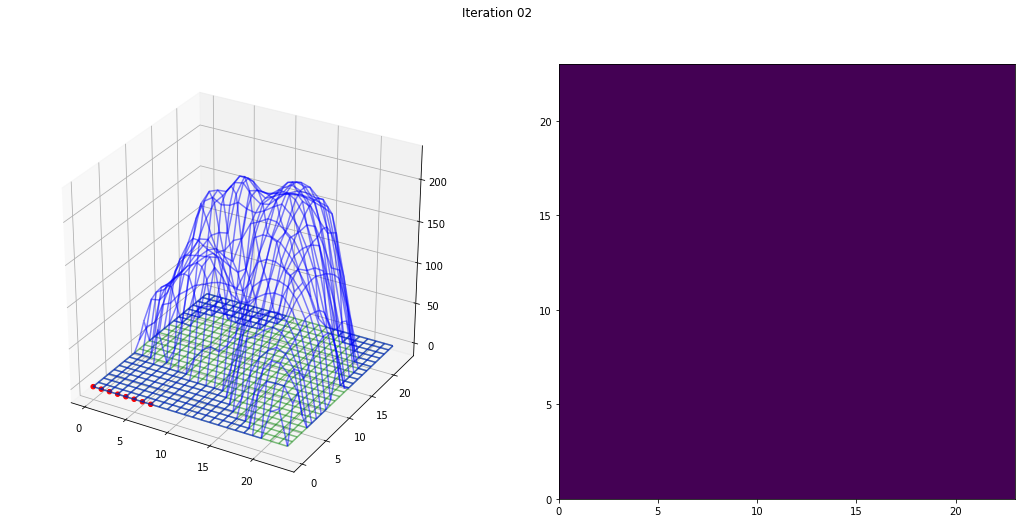

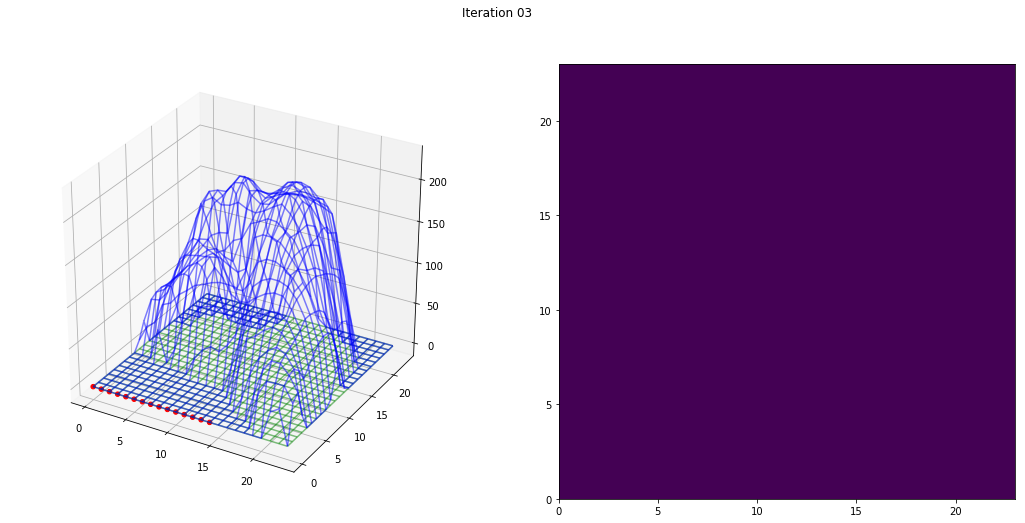

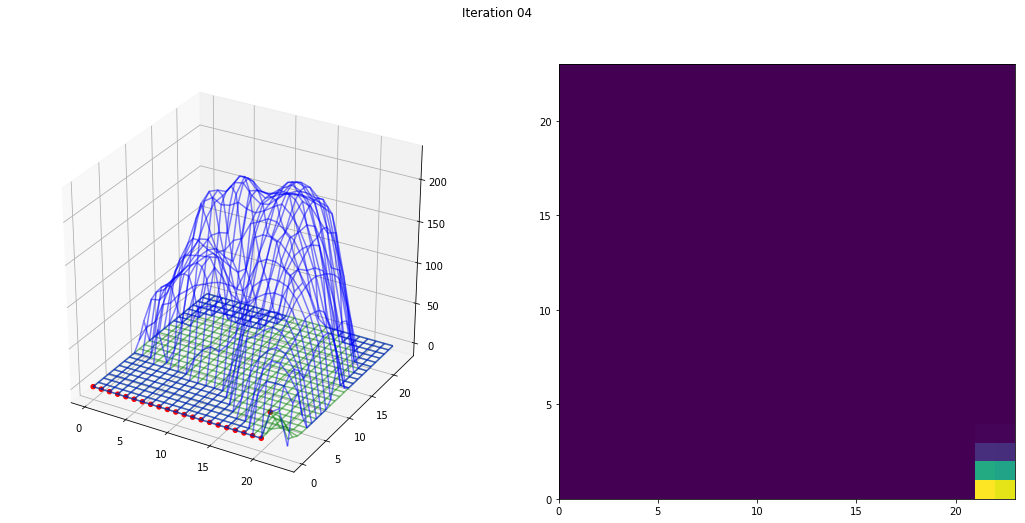

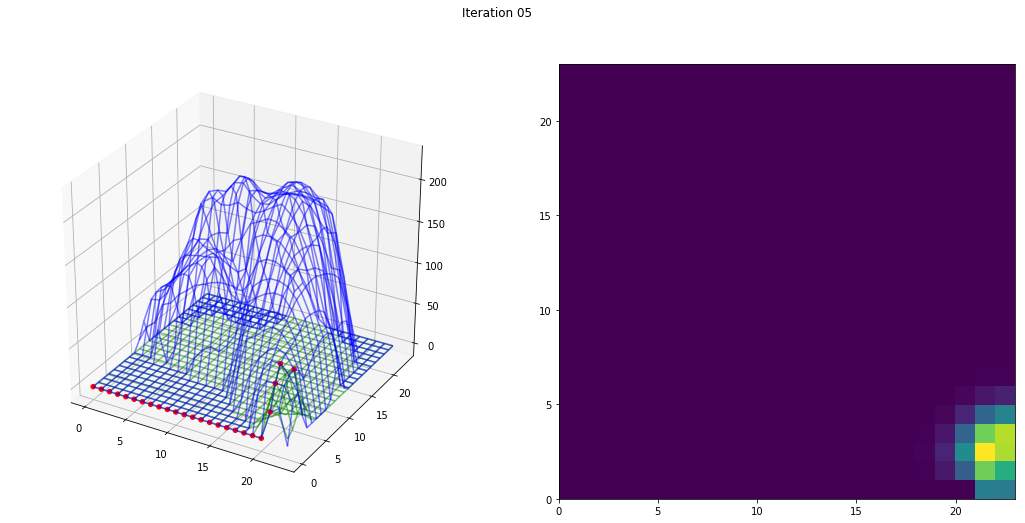

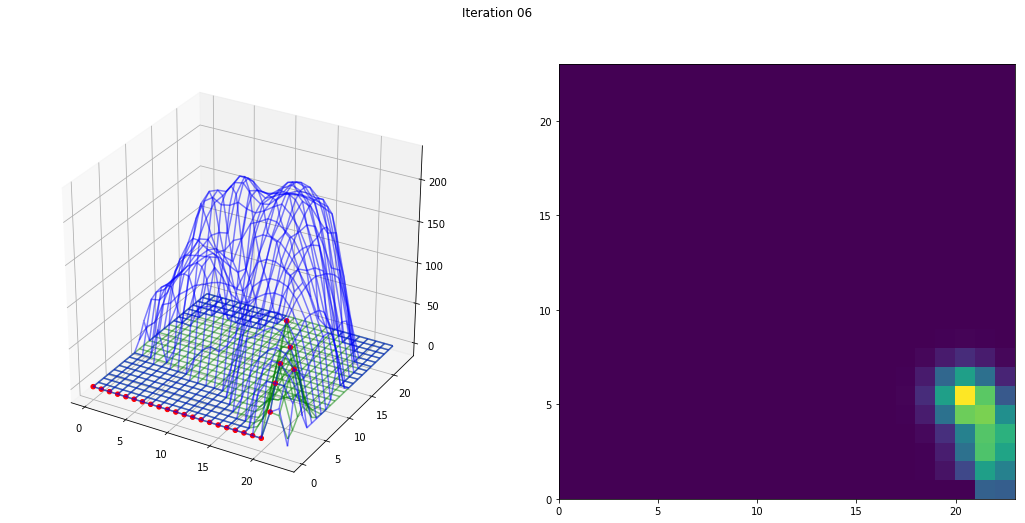

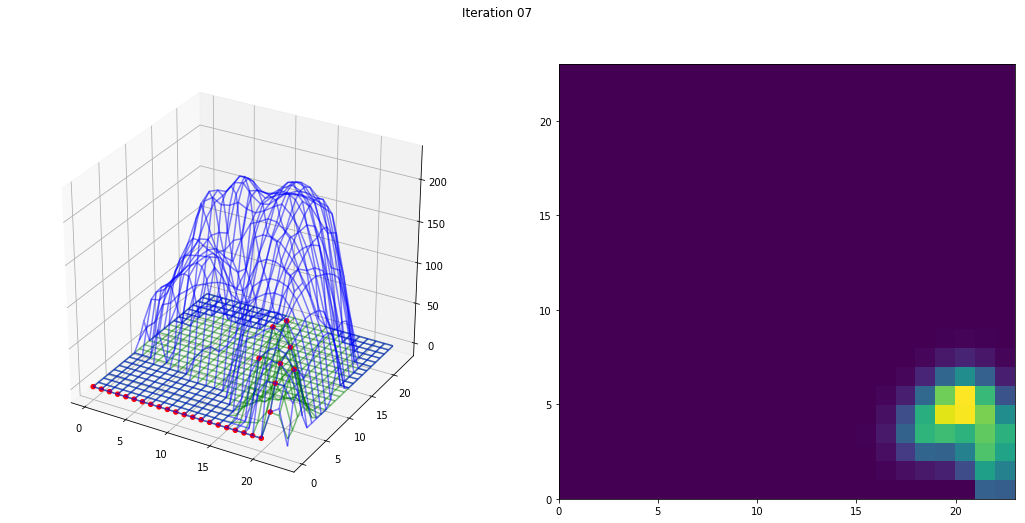

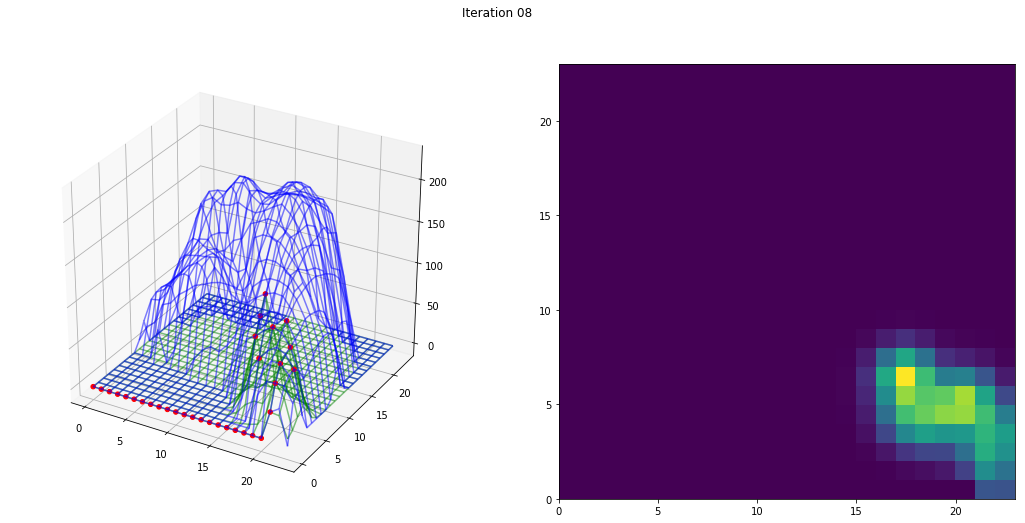

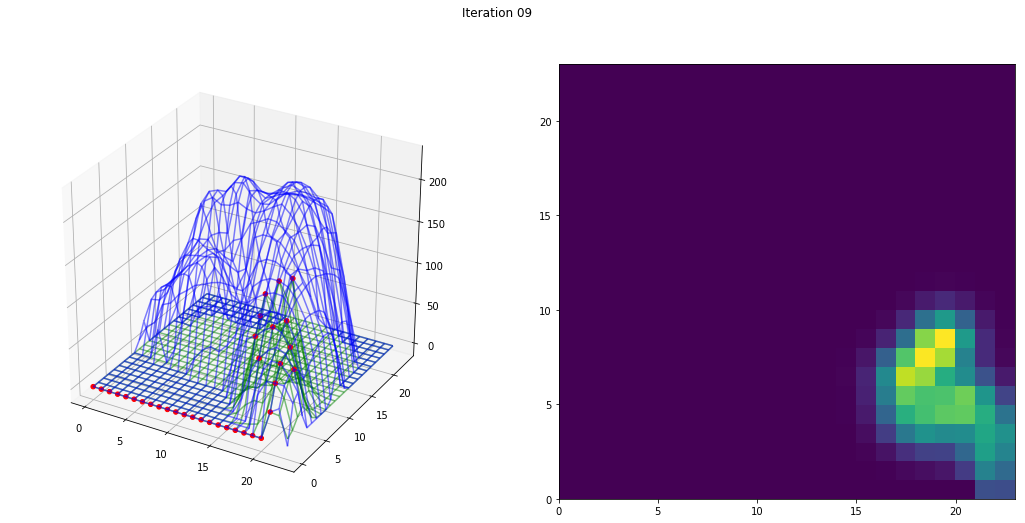

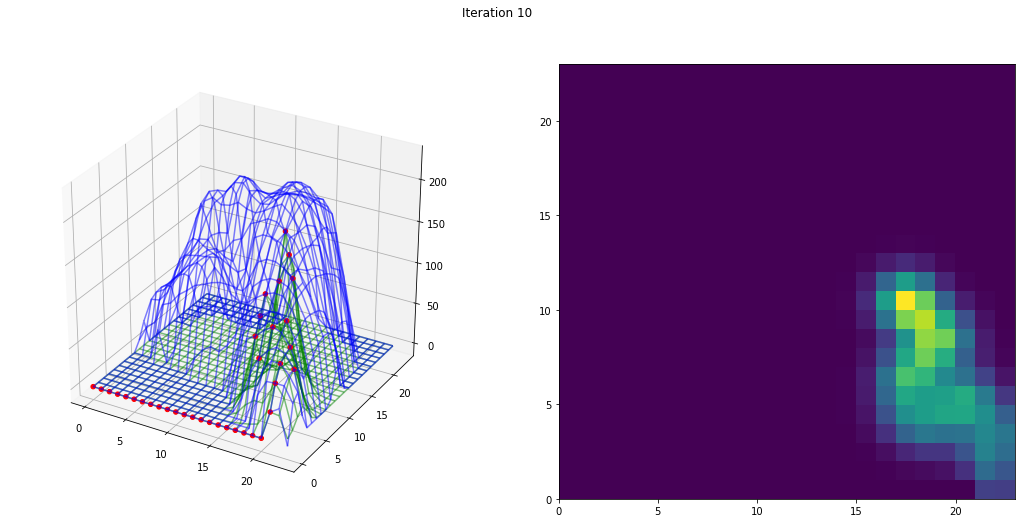

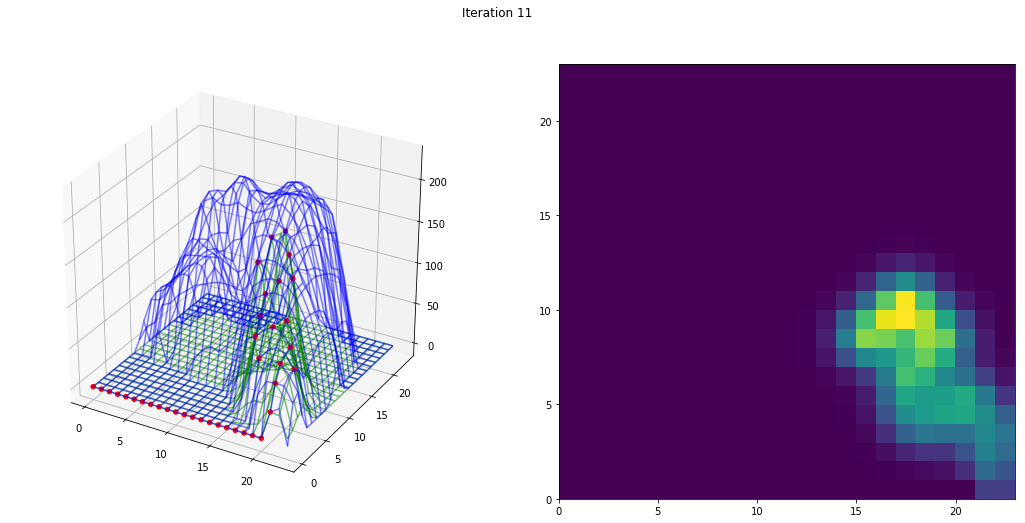

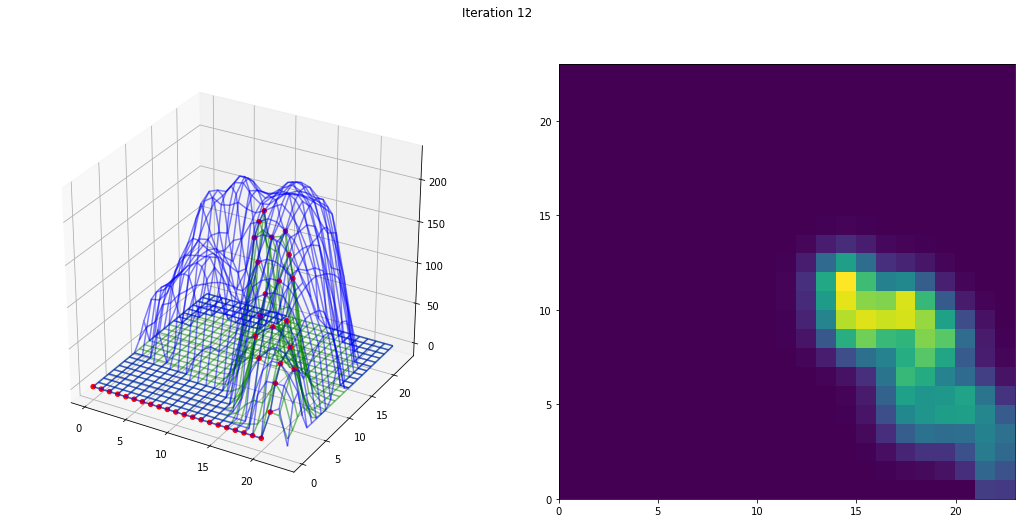

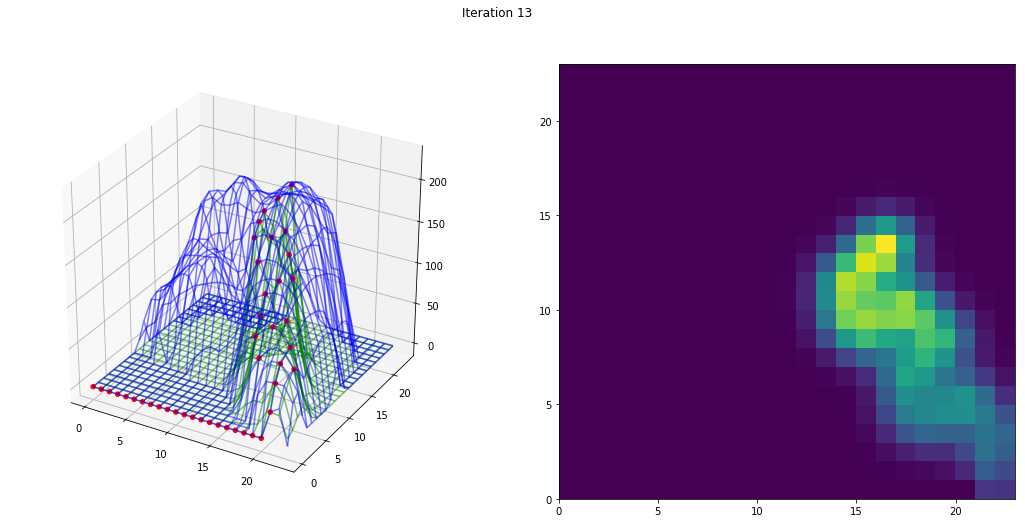

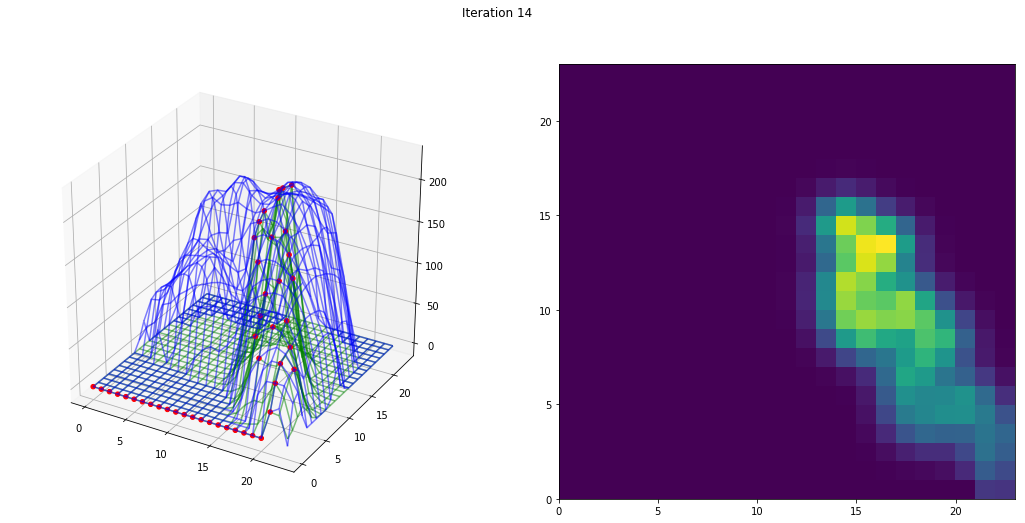

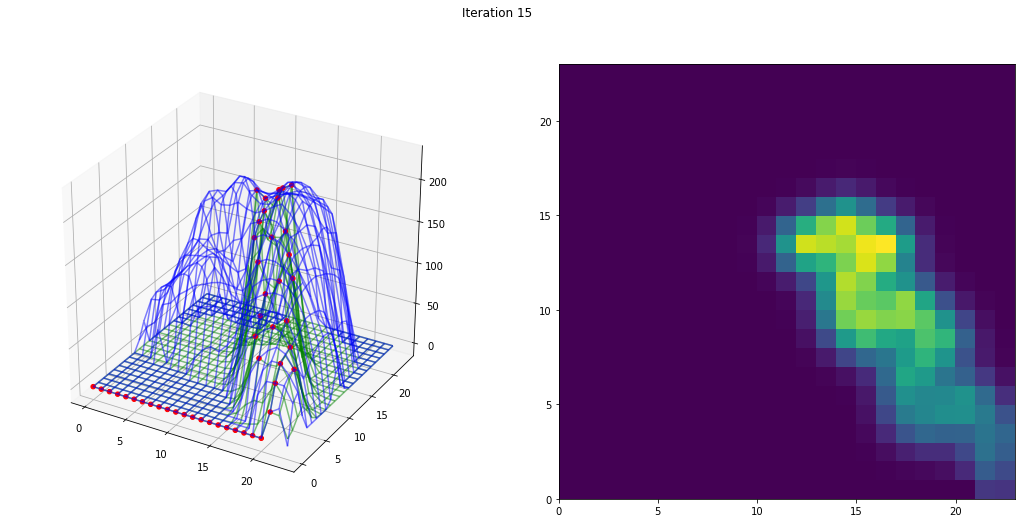

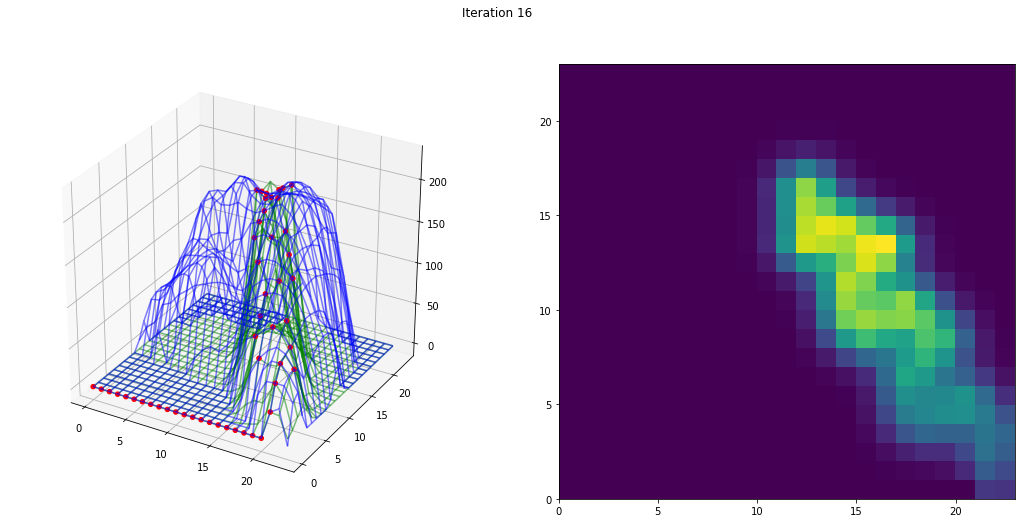

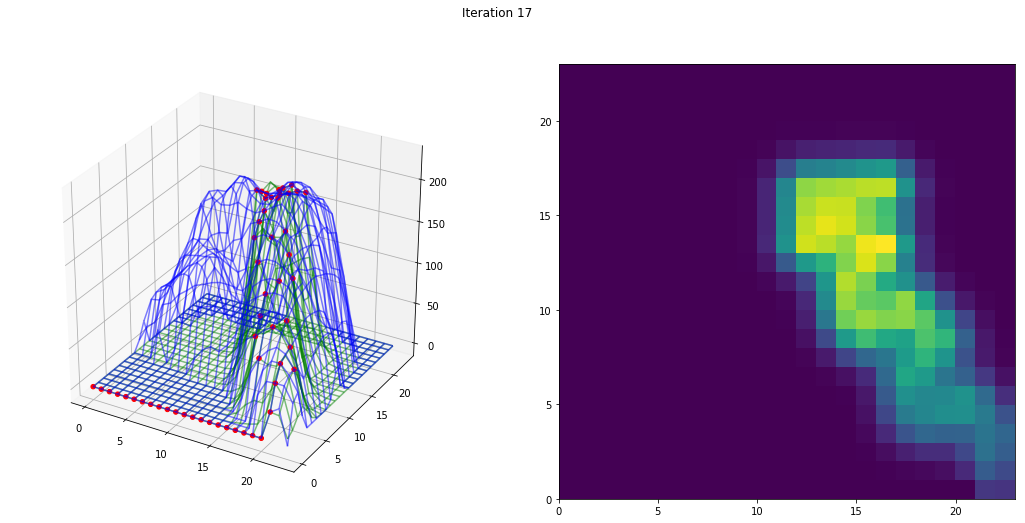

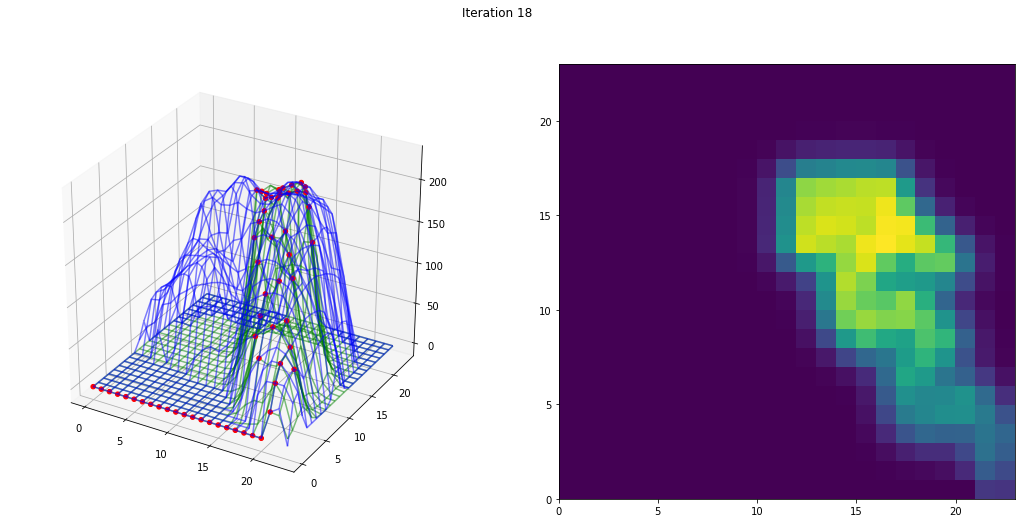

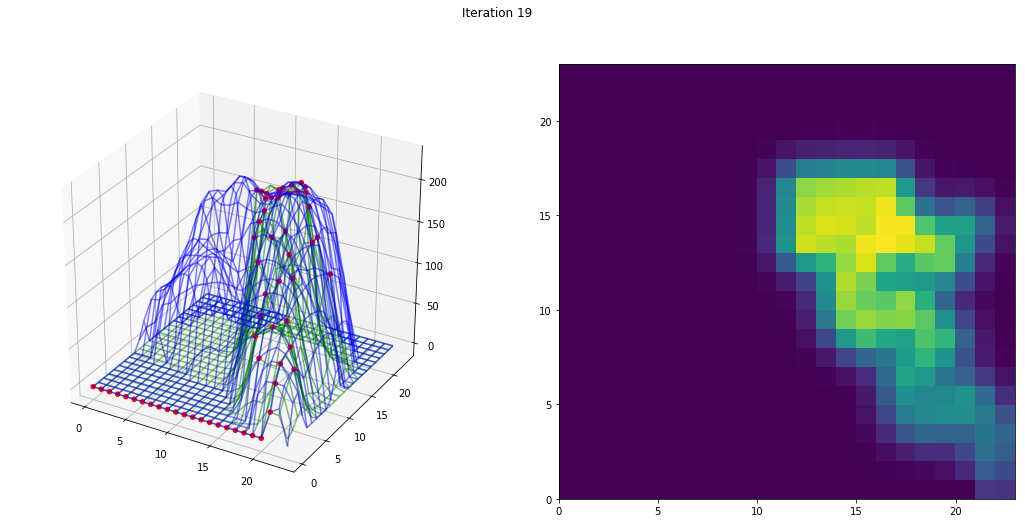

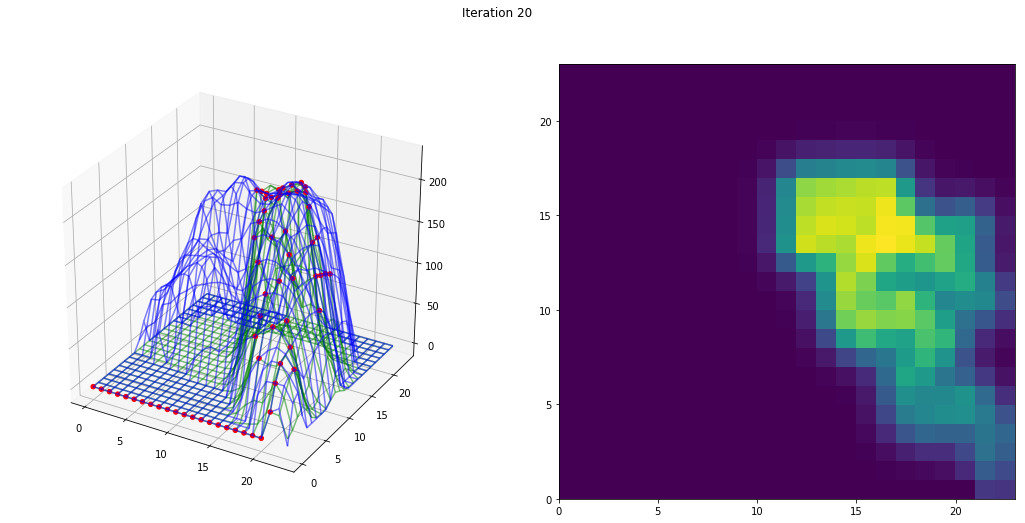

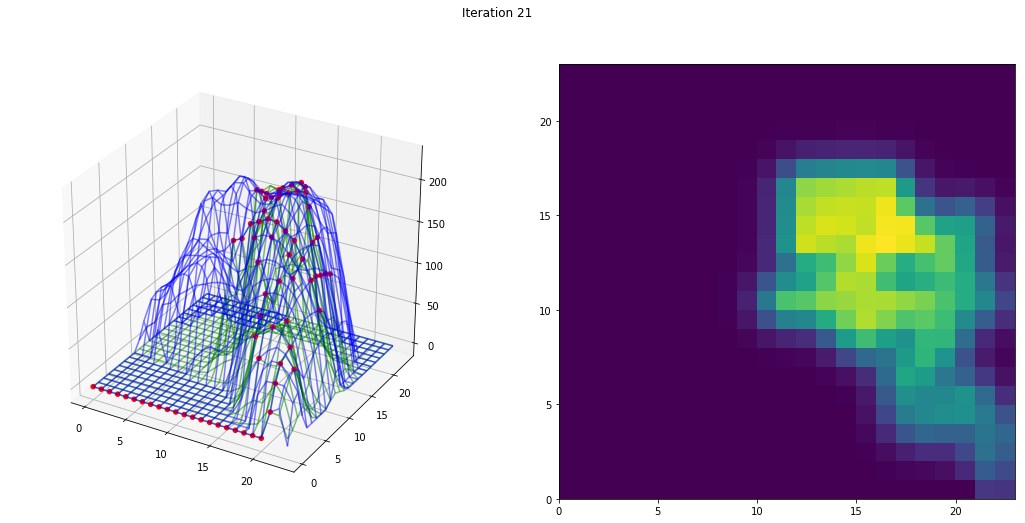

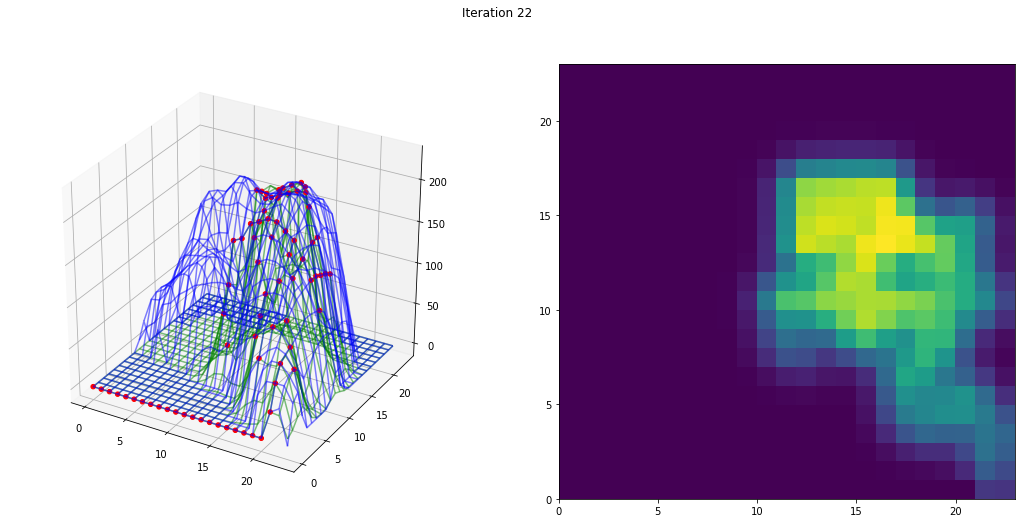

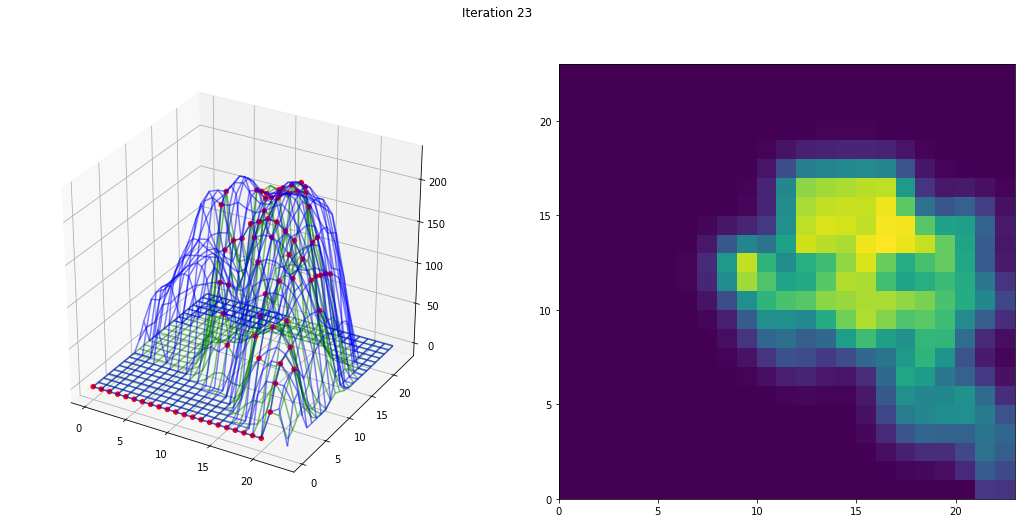

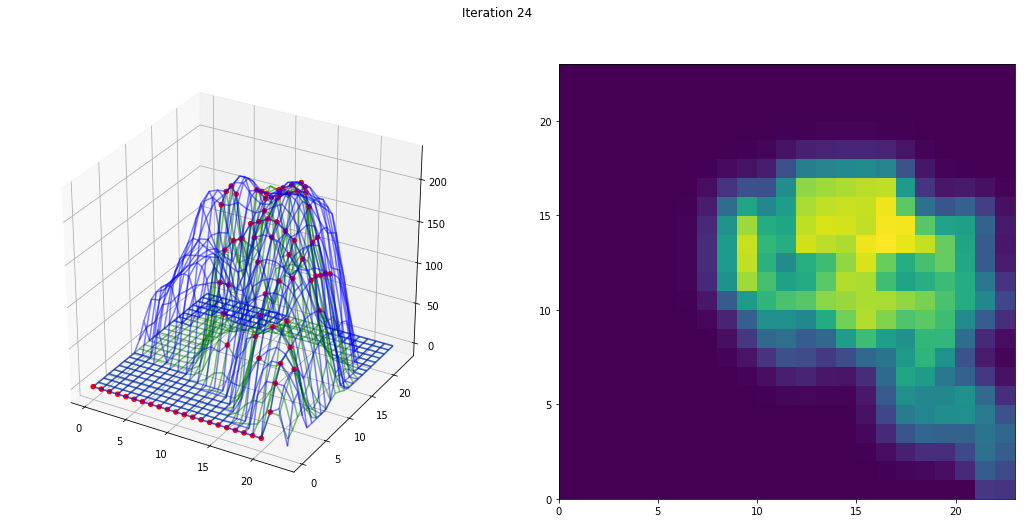

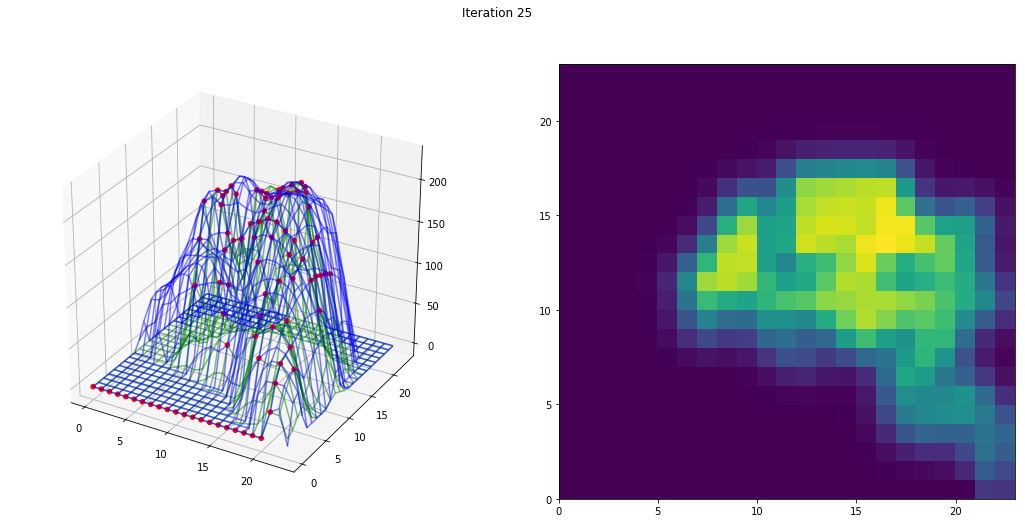

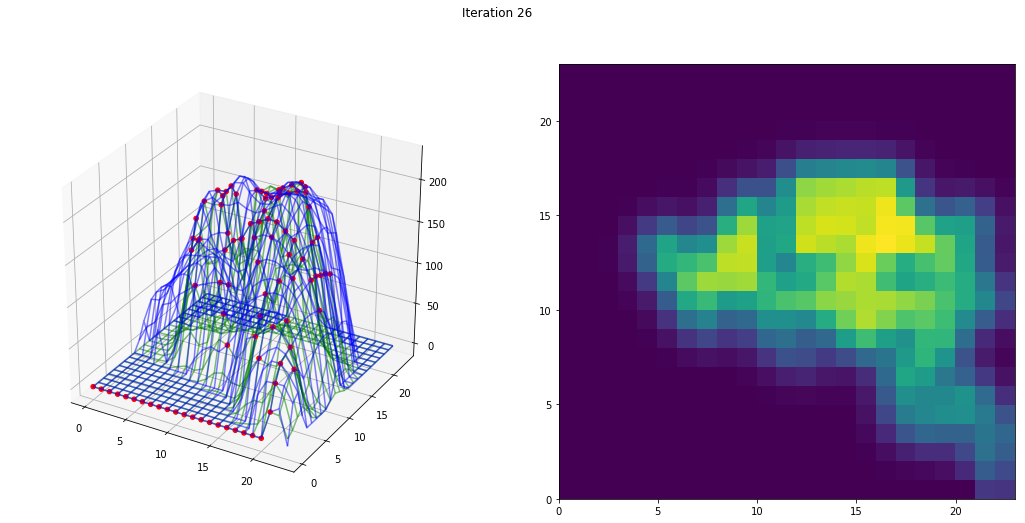

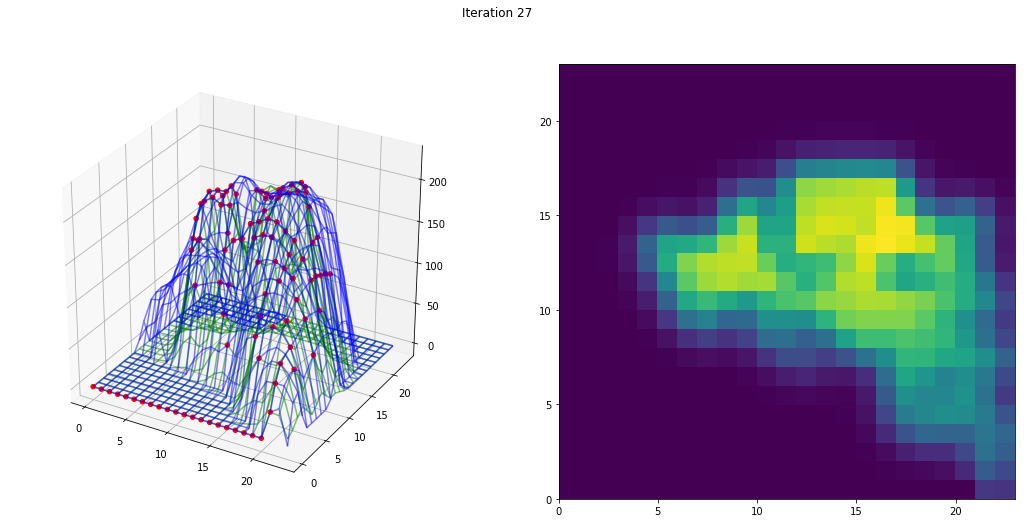

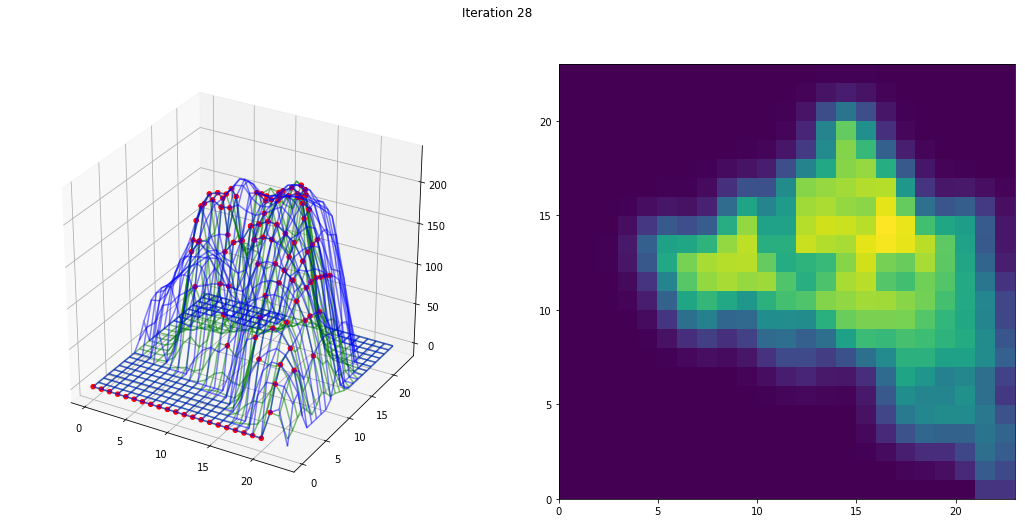

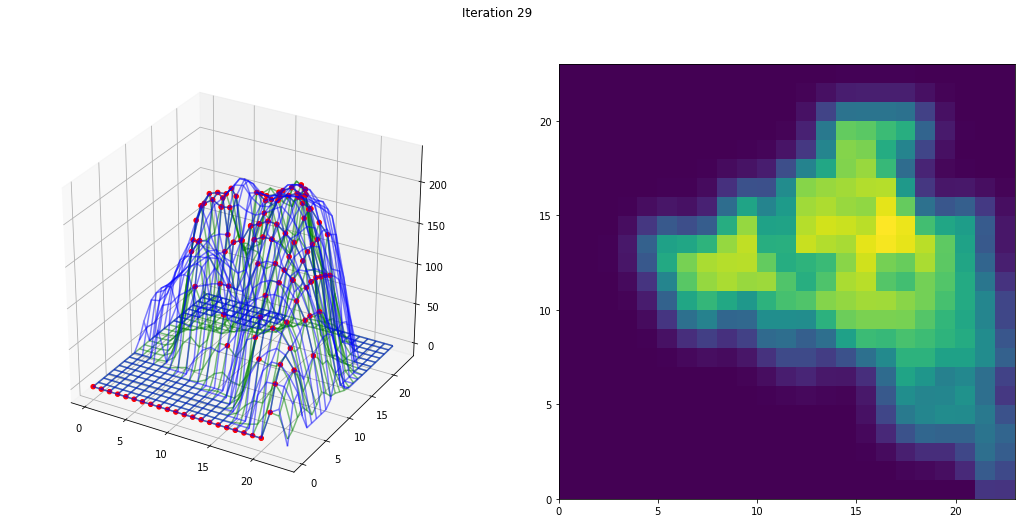

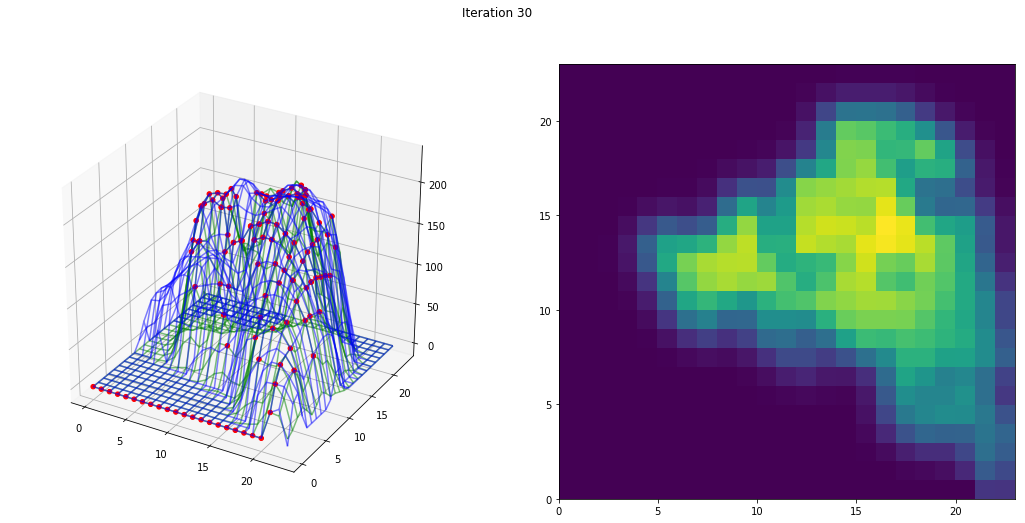

In [186]:
#Mapping the Field--
import time
d = 0
t = time.clock()
for i in range(30):
    #print "Sampling Location "+ str(i) + " is" 
    predicted, l = agent.learn()
    d+=l
    agent.plot()
    
print "Computational time", time.clock()-t
print "trajectory length", d
    

In [187]:
Z = img
k=0
error = []
for i in Z:
    for j in i:
        error.append(abs(j-predicted[k]))
        k+=1
        
MappingError = sum(error)
print "Mapping Error",MappingError

Mapping Error 11031.122805850973
